In [3]:
!pip install kneed

In [4]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


In [5]:
import pandas as pd
from kneed import KneeLocator
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
data = pd.read_csv("/content/gdrive/Shareddrives/PMA kelompok 5/Clustering.csv")
data.sample(10)

,news_title
522,iring pawai budaya pasang handal daftar pilkad...
427,lantik 50 anggota dprd kabupaten probolinggo k...
747,rsud genteng banyuwangi layan laser dioda solu...
862,kibar awards bappelitbangda kota banjar dorong...
241,siap guru profesional 234 mahasiswa stkip pgri...
765,pj gubernur adhy ekspor industri otomotif jati...
976,bangun nasionalisme arif lokal area wisata
1362,bbpp batu launching smart husbandry
160,komitmen aman aset daerah pemkot malang terima...
428,praktik bidan malang satron maling laku rekam ...


In [7]:
!wget -P /content/gdrive/Shareddrives/PMA\ kelompok\ 5/ -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"

--2024-11-11 05:01:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.115, 18.238.176.126, 18.238.176.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [8]:
from gensim.models import fasttext
model = fasttext.load_facebook_vectors('/content/gdrive/Shareddrives/PMA kelompok 5/cc.id.300.bin.gz')

In [9]:
# !pip install gensim
# !wget -P /content/gdrive/Shareddrives/PMA\ kelompok\ 5/ -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz"

# Fungsi untuk vektorisasi teks
def vectorize_text(text):
  words = text.lower().split()
  vectors = [model[word] for word in words if word in model.key_to_index]
  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(model.vector_size)

# Vektorisasi judul berita
X = np.array([vectorize_text(text) for text in data['news_title']])

In [10]:
data.shape

(1500, 1)

In [11]:
X.shape

(1500, 300)

In [12]:
print(X)

[[ 0.01693198  0.01983842  0.05808404 ...  0.01173753  0.0446523
   0.02472914]
 [ 0.04427719  0.00514167  0.00217737 ... -0.0282915   0.04046511
   0.03364106]
 [ 0.06469229 -0.02010454 -0.02934147 ...  0.01469474  0.02600419
  -0.02221175]
 ...
 [-0.0027249   0.02881463  0.01610753 ... -0.00115543 -0.00604041
   0.01666087]
 [ 0.00605182  0.0666388   0.03527098 ... -0.00589267  0.00091069
   0.09534323]
 [-0.00710561 -0.02285917  0.01088812 ... -0.01495914 -0.04033897
  -0.05586316]]


In [64]:
# Menggunakan PCA dengan dua komponen
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

In [65]:
X_pca.shape

(1500, 2)

In [66]:
# Variansi yang dijelaskan oleh setiap komponen utama
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = explained_variance_ratio.sum()

print("Variansi dijelaskan oleh komponen pertama:", explained_variance_ratio[0])
print("Variansi dijelaskan oleh komponen kedua:", explained_variance_ratio[1])
print("Total variansi yang dijelaskan oleh dua komponen:", total_variance_explained)

Variansi dijelaskan oleh komponen pertama: 0.1627026
Variansi dijelaskan oleh komponen kedua: 0.056121454
Total variansi yang dijelaskan oleh dua komponen: 0.21882406


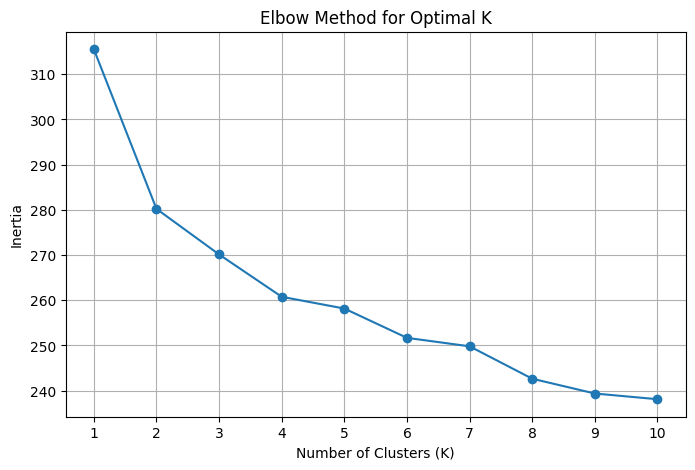

In [67]:
# Metode Elbow
inertia = []
K = range(1, 11)  # Mencoba nilai K dari 1 hingga 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(K)
plt.grid()
plt.show()


In [68]:
# Menggunakan KneeLocator untuk mendeteksi titik elbow
kneedle = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow

print("Nilai K optimal berdasarkan metode elbow:", optimal_k)

Nilai K optimal berdasarkan metode elbow: 4


In [69]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)
data['cluster'] = kmeans.labels_

In [70]:
#Menghitung Silhouette Score
score = silhouette_score(X_pca, data['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.4304773807525635


Cluster 0: Silhouette Score = 0.339
Cluster 1: Silhouette Score = 0.541
Cluster 2: Silhouette Score = 0.364
Cluster 3: Silhouette Score = 0.189


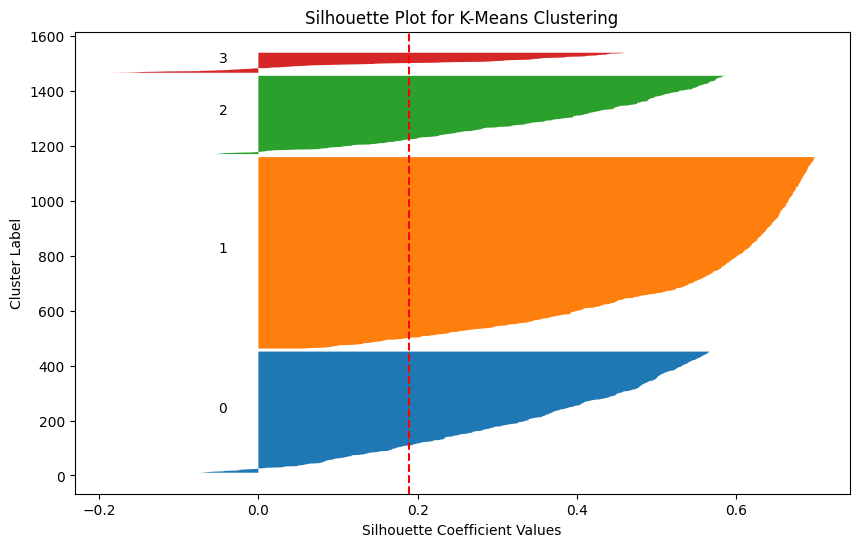

In [78]:
#Menghitung Silhouette Score untuk setiap titik
silhouette_vals = silhouette_samples(X_pca, data['cluster'])

#Menampilkan nilai Silhouette per cluster
silhouette_per_cluster = {}
for i in range(optimal_k):
    # Ambil nilai Silhouette untuk cluster i
    cluster_vals = silhouette_vals[data['cluster'] == i]
    silhouette_per_cluster[i] = cluster_vals.mean()  # Rata-rata nilai Silhouette

# Menampilkan hasil
for cluster, score in silhouette_per_cluster.items():
    print(f'Cluster {cluster}: Silhouette Score = {score:.3f}')

#Visualisasi Silhouette Score
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    # Menentukan lokasi yang tepat untuk cluster
    ith_cluster_silhouette_values = silhouette_vals[data['cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                       0, ith_cluster_silhouette_values)
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper + 10  # Menambahkan jarak antara cluster

plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.title('Silhouette Plot for K-Means Clustering')
plt.axvline(x=score, color='red', linestyle='--')  # Garis untuk nilai rata-rata Silhouette Score
plt.show()

In [76]:
# Menampilkan judul berdasarkan cluster
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(data[data['cluster'] == i]['news_title'].head(10))  # Tampilkan 10 judul per cluster


Cluster 0:
20    konsolidasi rejo semut ireng menang paslon bug...
24      tyronne del pino main persib baik fifa matchday
36    wapres ma ruf amin datang paus fransiskus bawa...
41    uin maliki malang kejar akreditasi internasion...
42    dinas pu bina marga kabupaten malang baik akse...
57    kpu banyuwangi tambah 3 hari paslon baik berka...
59    50 anggota dprd lantik bupati serang harap lak...
75                   wamen atr bpn didik tiket personal
79    menang pasang sashabila mus la ode yasir ahmad...
91    pasca banjir bandang ternate menteri pupr ri f...
Name: news_title, dtype: object

Cluster 1:
0                                      ultra mikro umkm
1                        who cepat vaksinasi polio gaza
3     tani tembakau jombang curhat hasil panen bagus...
4     momen paus fransiskus istana sambut jokowi kar...
5                 paus fransiskus banjir puji sederhana
6     program bunga desa bupati banyuwangi salur ban...
7         paham literasi finansial komprehensif 

In [79]:
# Simpan hasil clustering ke file CSV
data_sorted = data.sort_values(by=['cluster'])
data_sorted.to_csv('hasil_clustering_Word2Vec_sorted.csv', index=False)

from google.colab import files
files.download('hasil_clustering_Word2Vec_sorted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Jumlah berita per cluster:
cluster
1    698
0    442
2    286
3     74
Name: count, dtype: int64


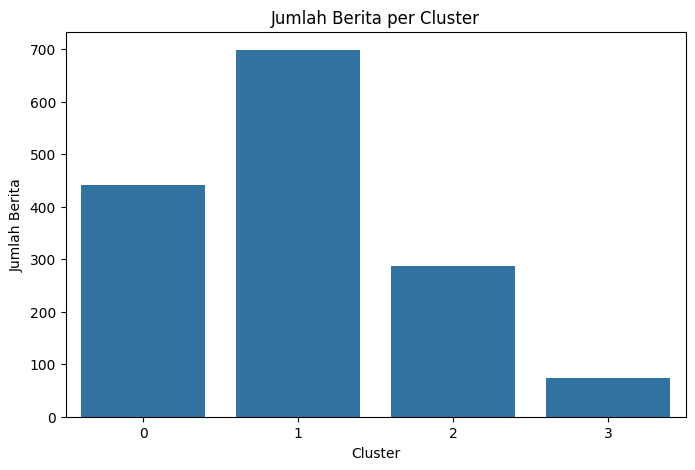

In [80]:
# Menghitung jumlah berita per cluster
cluster_counts = data['cluster'].value_counts()
print("\nJumlah berita per cluster:")
print(cluster_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Jumlah Berita')
plt.title('Jumlah Berita per Cluster')
plt.xticks(cluster_counts.index)
plt.show()

In [82]:
# Mendapatkan posisi centroid untuk setiap cluster
centroids = kmeans.cluster_centers_
centroids

array([[-0.00351486, -0.09271634],
       [ 0.13448831,  0.02617649],
       [-0.19515795,  0.10842042],
       [-0.49329725, -0.11214639]], dtype=float32)

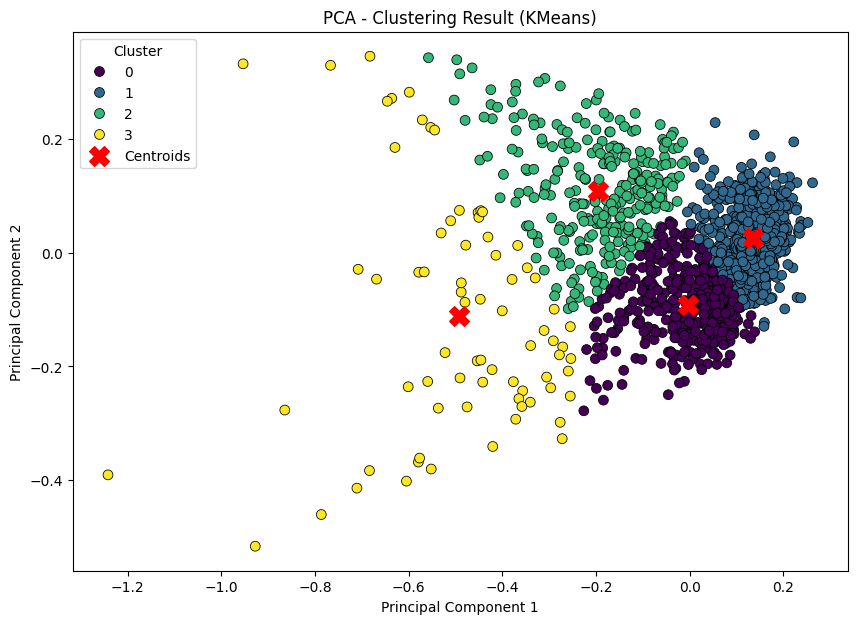

In [84]:
# Visualisasi scatter plot untuk dua komponen pertama dari PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=data['cluster'],
    palette="viridis",
    s=50,
    edgecolor="k"
)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200,
    c="red",
    marker="X",
    label="Centroids"
)
plt.title('PCA - Clustering Result (KMeans)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [85]:
# Cek jumlah k cluster lainnya
silhouette_scores = {}

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_pca, labels)
    silhouette_scores[k] = score

silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['K', 'Silhouette Score'])
print(silhouette_df)

   K  Silhouette Score
0  2          0.539395
1  3          0.394540
2  4          0.430477
3  5          0.433651
4  6          0.428155
5  7          0.349471
6  8          0.350099
7  9          0.350657


# Fuzzy C-Means

In [87]:
!pip install fuzzy-c-means==1.7.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5


In [88]:
from IPython import get_ipython
from IPython.display import display
from fcmeans import FCM # Import FCM untuk C-Means